In this notebook, we build our final dataset for the S&P500 index.

In [1]:
'''
Importing necessary libraries
'''
from utils import transform_to_float
import matplotlib.pyplot as plt
from dateutil import rrule, parser
import os
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
%load_ext autoreload
%autoreload 2

In [ ]:
'''
Functions for getting data from Alpha Vantage and Twelve Data
'''

def get_data_alpha_vantage(start_date, end_date, stock_symbol):
    months = list(rrule.rrule(rrule.MONTHLY, dtstart=parser.parse(start_date), until=parser.parse(end_date)))

    # Initialize an empty list to store the DataFrames
    dfs = []

    # Loop over the list of months
    for month in months:
        # Format the current month into the required format for the API request
        formatted_month = month.strftime("%Y-%m")

        # Make the API request and get the response
        url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={stock_symbol}&interval=5min&month={formatted_month}&outputsize=full&apikey=V9AMYI6A7YVMUUZZ"
        r = requests.get(url)
        monthly_data = r.json()
        try:
            df = pd.DataFrame(monthly_data["Time Series (5min)"]).transpose()[::-1]
        except:
            print(month)
            print(monthly_data)
            data = pd.concat(dfs)
            break
        # Convert the response JSON into a DataFrame and transpose it
        # Append the DataFrame to the list of DataFrames
        dfs.append(df)

    # Concatenate all the DataFrames in the list into a single DataFrame
    data = pd.concat(dfs)
    return data


def merge_data_alpha_vantage(data_directory, stock_symbol):
    # List to store DataFrames
    dfs = []

    data_directory = os.path.join(data_directory, stock_symbol)

    # Iterate over files in the directory
    for file in os.listdir(data_directory):
        if file.endswith(".csv") and file.startswith("data_"):
            # Read CSV file into DataFrame with the first column as index and parse dates
            file_path = os.path.join(data_directory, file)
            df = pd.read_csv(file_path, index_col=0, parse_dates=[0])

            # Append DataFrame to the list
            dfs.append(df)

    # Concatenate all DataFrames
    concatenated_df = pd.concat(dfs)
    concatenated_df.drop_duplicates(inplace=True)

    # Sort the index based on the date
    concatenated_df.sort_index(inplace=True)

    return concatenated_df


def get_data_twelve_data(stock_symbol, start_date, end_date):
    # Define start and end dates

    # Initialize an empty list to store dataframes
    dfs = []

    # Define the interval for each request (3 months)
    interval = timedelta(days=3 * 30)

    # Make requests in a loop
    while start_date < end_date:
        # Define end date for the current request (3 months ahead)
        request_end_date = min(start_date + interval, end_date)

        # Format dates as strings
        start_date_str = start_date.strftime("%Y-%m-%d %H:%M:%S")
        request_end_date_str = request_end_date.strftime("%Y-%m-%d %H:%M:%S")

        # Make request
        response = requests.get(
            f"https://api.twelvedata.com/time_series?apikey=92e1895b6d9140719689a551a2a7ddcf&interval=5min&symbol={stock_symbol}&start_date={start_date_str}&end_date={request_end_date_str}&format=JSON")

        # Convert response to JSON format
        json_data = response.json()

        # Convert JSON data to DataFrame
        data = pd.DataFrame(json_data['values'])[::-1]

        # Set datetime column as index
        data['datetime'] = pd.to_datetime(data['datetime'])
        data.set_index('datetime', inplace=True)

        # Append dataframe to the list
        dfs.append(data)

        # Update start date for the next request
        start_date = request_end_date

        # Pause to ensure at most 6 requests per minute
        time.sleep(10)

    # Concatenate all dataframes
    merged_df = pd.concat(dfs)

    merged_df = merged_df.drop_duplicates()
    # Print the merged dataframe
    return merged_df


In [42]:
'''
Here we get the data of VOO ticker from Alpha Vantage for the period which we don;t have data from Twelve Data
'''

start_date = '2020-01-01'
end_date = '2020-04-01'
stock_symbol = 'VOO'

data = get_data_alpha_vantage(start_date, end_date, stock_symbol)

data.to_csv(f'Data/{stock_symbol}/data_{stock_symbol}_{start_date}.csv')


In [6]:
'''
Getting the data of S&P from Twelve Data
'''
start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 1, 1)
stock_symbol = 'SPX'

data = get_data_twelve_data(stock_symbol, start_date, end_date)
data.to_csv(f'Data/{stock_symbol}/{stock_symbol}_data_twelvedata.csv')

Make the dataset for S&P500

In [2]:
'''
Read the data of S&P500 from Oxford Man Institute and calculate the realized volatility
'''
oxford_rv = pd.read_csv('Data/Indexes/MAN_data.csv', index_col=0)
oxford_rv = oxford_rv.loc[oxford_rv['Symbol'] == '.SPX']
oxford_rv.drop(columns=['Symbol'], inplace=True)
oxford_rv['rv5'] = oxford_rv['rv5'] ** 0.5
oxford_rv = oxford_rv[['rv5', 'close_price']]
oxford_rv.index = pd.to_datetime(oxford_rv.index, utc=True)
oxford_rv.index = oxford_rv.index.date
oxford_rv.index = pd.to_datetime(oxford_rv.index)
oxford_rv['return'] = np.log(oxford_rv['close_price'] / oxford_rv['close_price'].shift(1))
oxford_rv.dropna(inplace=True)
oxford_rv = oxford_rv[['rv5', 'return']]
oxford_rv.tail()

,rv5,return
2020-01-27,0.006460,-0.015964
2020-01-28,0.004526,0.010136
2020-01-29,0.005054,-0.000849
2020-01-30,0.007282,0.003059
2020-01-31,0.009274,-0.018014


In [9]:
'''
Read the 5-min data of S&P500 from Twelve Data and calculate the realized volatility
'''
twelve_data_SP = pd.read_csv('Data/SPX/SPX_data_twelvedata.csv', index_col=0)
twelve_data_SP.index = pd.to_datetime(twelve_data_SP.index)

# Calculate return and volume
twelve_data_SP['rv5'] = np.log(twelve_data_SP['close'] / twelve_data_SP['close'].shift(1))


daily_twelve = twelve_data_SP.resample('D').agg({'close': 'last', 'rv5': lambda x: (x ** 2).sum()}) 

daily_twelve = daily_twelve.loc[np.unique(twelve_data_SP.index.date)]

daily_twelve.dropna(inplace=True)

daily_twelve['return'] = np.log(daily_twelve['close'] / daily_twelve['close'].shift(1))

daily_twelve.dropna(inplace=True)

daily_twelve['rv5'] = np.sqrt(daily_twelve['rv5'])

daily_twelve = daily_twelve[['rv5', 'return']]

daily_twelve.head()


,rv5,return
datetime,,
2020-02-25,0.016191,-0.030327
2020-02-26,0.017926,-0.004102
2020-02-27,0.034247,-0.044221
2020-02-28,0.043393,-0.009103
2020-03-02,0.025765,0.044730


In [10]:
'''
Read the 5-min data of VOO from Alpha Vantage and calculate the realized volatility
'''
VOO = pd.read_csv('Data/VOO/data_VOO_2020-01-01.csv', index_col=0)
VOO.index = pd.to_datetime(VOO.index)

VOO.rename(columns={'4. close': 'close_price'}, inplace=True)

VOO['rv5'] = np.log(VOO['close_price'] / VOO['close_price'].shift(1))


daily_VOO = VOO.resample('D').agg({'close_price': 'last', 'rv5': lambda x: (x ** 2).sum()}) 

daily_VOO = daily_VOO.loc[np.unique(VOO.index.date)]

daily_VOO.dropna(inplace=True)

daily_VOO['return'] = np.log(daily_VOO['close_price'] / daily_VOO['close_price'].shift(1))

daily_VOO.dropna(inplace=True)

daily_VOO['rv5'] = np.sqrt(daily_VOO['rv5'])

daily_VOO = daily_VOO[['rv5', 'return']]

daily_VOO.head()


,rv5,return
2020-01-03,0.013600,-0.008575
2020-01-06,0.008321,0.004246
2020-01-07,0.007631,-0.016956
2020-01-08,0.025023,0.021884
2020-01-09,0.004946,0.005908


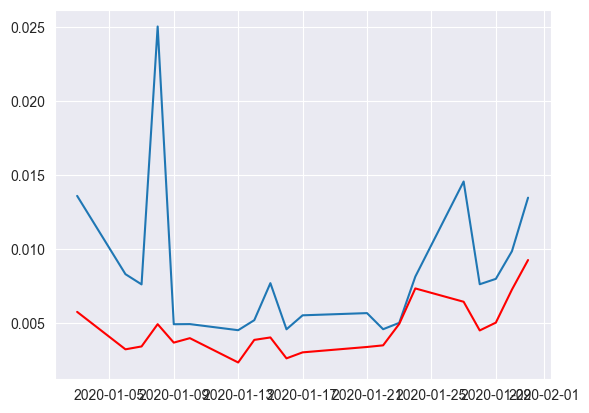

In [20]:
'''
check the consistency between the oxford S&P realized volatility and the realized volatility calculated from the VOO ticker data
'''
common_indexes = daily_VOO.index.intersection(oxford_rv.index)
plt.plot(daily_VOO.loc[common_indexes]['rv5'])
plt.plot(oxford_rv.loc[common_indexes]['rv5'], color = 'red')

In [134]:
'''
Merge the data of VOO and twelve data
'''
indices_not_in_twelve = daily_VOO.index.difference(daily_twelve.index)

daily_VOO = daily_VOO.loc[indices_not_in_twelve]

merged_data = pd.concat([daily_VOO, daily_twelve])
merged_data.head()

,rv5,return
2020-01-03,0.013600,-0.008575
2020-01-06,0.008321,0.004246
2020-01-07,0.007631,-0.016956
2020-01-08,0.025023,0.021884
2020-01-09,0.004946,0.005908


In [135]:
'''
Merge all the data
'''
non_mutual_indices = merged_data.index.difference(oxford_rv.index)

merged_data = merged_data.loc[non_mutual_indices]

final_data = pd.concat([oxford_rv, merged_data])

In [137]:
'''
Save the final data
'''
final_data.to_csv('Data/SPX/SPX_final_data.csv')